# Using clustering not classification on breast-cancer dataset

**2017301470026 王淳**

In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)
%load_ext rpy2.ipython
%R require(NbClust)

/Users/hubble/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/Users/hubble/opt/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: NbClust

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [2]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import normalized_mutual_info_score

In [3]:
def model_selection(model, data, labels_ture):
    labels_pred = model.fit_predict(data)
    nmi = f'{normalized_mutual_info_score(labels_ture, labels_pred):.4f}'
    return labels_pred, nmi

# 导入数据集

In [4]:
df = pd.read_csv('breast.csv', sep=' ', header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'label']

In [5]:
df.label.value_counts()

2.0    458
4.0    241
Name: label, dtype: int64

Insights:
- 真实数据一共有两种类别，其中良性编码为2，恶性编码为4

# 分离数据和真实标签

In [6]:
labels_true = np.array(df.label)
data = df.iloc[:, :-1]
data.head(10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0
5,8.0,10.0,10.0,8.0,7.0,10.0,9.0,7.0,1.0
6,1.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,1.0
7,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0
8,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0
9,4.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0


# 数据预处理

In [7]:
data = MinMaxScaler().fit_transform(data)

# 平均距离层次聚类

## 聚成两类

In [8]:
%%R
data <- read.table('breast.csv', header = F)
data <- data[1:9]
data.scaled <- scale(data)  # 数据标准化
d <- dist(data.scaled)      # 计算欧氏距离
fit.average <- hclust(d, method = 'average')
set.seed(42)
clusters <- cutree(fit.average, k=2)

class_1 <- which(clusters == 1)
class_2 <- which(clusters != 1)

In [9]:
%R -o class_1,class_2

class_1 = np.asarray(class_1)
class_2 = np.asarray(class_2)

labels_pred = np.zeros_like(labels_true)
labels_pred[class_1 - 1] = 2
labels_pred[class_2 - 1] = 4

print('==========平均距离层次聚类聚成两类的评估==========\n')
print(f'NMI指标：{normalized_mutual_info_score(labels_true, labels_pred):.4f}')
print(f'准确率： {np.mean(labels_true == labels_pred)*100:.2f}%')
print(f'错误数目：{sum(labels_true != labels_pred)}')

==========平均距离层次聚类聚成两类的评估==========

NMI指标：0.1392
准确率： 70.82%
错误数目：204


## 聚类数寻优

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 3 proposed 2 as the best number of clusters 
* 15 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 4 proposed 5 as the best number of clusters 

                   ***** Conclus

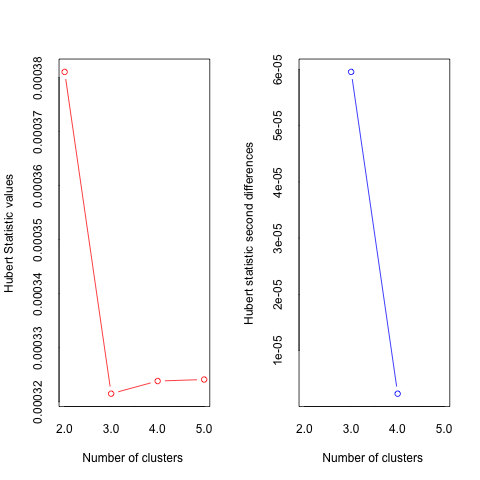

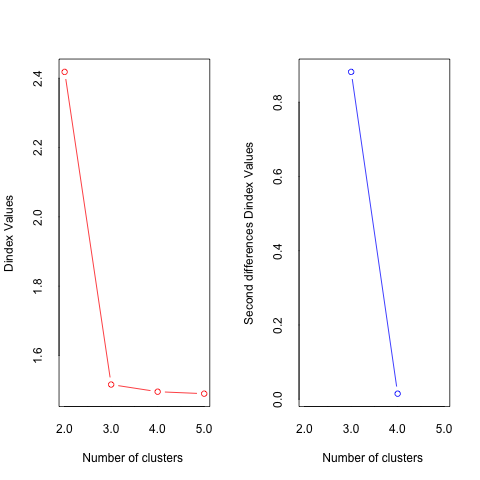

In [10]:
%%R
nc <- NbClust(data.scaled, distance="euclidean", 
              min.nc=2, max.nc=5, method="average")


 0  1  2  3  4  5 
 2  1  3 15  1  4 


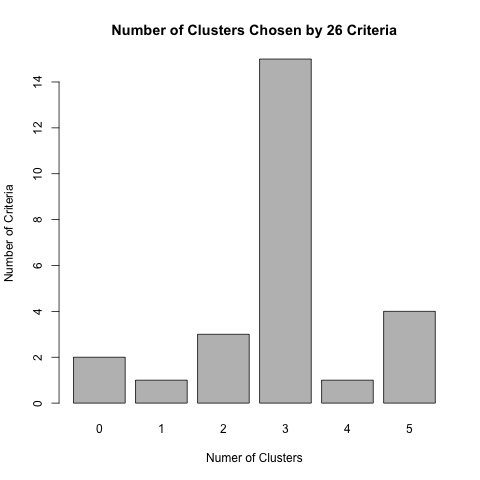

In [11]:
%%R
barplot(table(nc$Best.n[1,]), 
        xlab="Numer of Clusters", ylab="Number of Criteria",
        main="Number of Clusters Chosen by 26 Criteria") 
table(nc$Best.n[1,])

Insights:
- 26个聚类评估准则中有15个推荐将样本聚成3类

## 根据最佳聚类数划分

In [12]:
%%R
clusters <- cutree(fit.average, k=3)
print('每个类中的样本数目')
table(clusters)

[1] "每个类中的样本数目"
clusters
  1   2   3 
455 207  37 


In [13]:
%%R
print('每个类中的变量中位数')
aggregate(data, by=list(cluster=clusters), median)

[1] "每个类中的变量中位数"
  cluster V1 V2 V3 V4 V5 V6 V7 V8 V9
1       1  3  1  1  1  2  1  2  1  1
2       2  8  6  6  5  5 10  6  6  1
3       3  8 10 10  8  7 10  7  8  8


Insight:
- 三个类别存在明显区别，根据数据集描述，可确定第一类为良性，第三类为恶性，而第二类为中间过渡阶段
- 考虑到第三类样本过少，考虑将第二类和第三类合并，将过渡阶段合并到恶性与日常生活经验是不矛盾的

## 适当合并聚类结果

In [14]:
%%R
class_1 <- which(clusters == 1)
class_2 <- which(clusters != 1)

In [15]:
%R -o class_1,class_2

class_1 = np.asarray(class_1)
class_2 = np.asarray(class_2)

labels_pred = np.zeros_like(labels_true)
labels_pred[class_1 - 1] = 2
labels_pred[class_2 - 1] = 4

print('==========平均距离层次聚类聚成三类再合并成两类的评估==========\n')
print(f'NMI指标：{normalized_mutual_info_score(labels_true, labels_pred):.4f}')
print(f'准确率： {np.mean(labels_true == labels_pred)*100:.2f}%')
print(f'错误数目：{sum(labels_true != labels_pred)}')

==========平均距离层次聚类聚成三类再合并成两类的评估==========

NMI指标：0.7501
准确率： 96.14%
错误数目：27


# k-means

## 聚成两类

In [16]:
model = KMeans(n_clusters=2, random_state=42)
labels_pred = model.fit_predict(data)

for i in range(len(labels_pred)):
    if labels_pred[i] == 0:
        labels_pred[i] = 2
    else:
        labels_pred[i] = 4
        
nmi = normalized_mutual_info_score(labels_true, labels_pred)
print('==========k-means聚成两类的评估==========\n')
print(f'NMI指标：{nmi:.4f}')
print(f'准确率： {np.mean(labels_true == labels_pred)*100:.2f}%')
print(f'错误数目：{sum(labels_true != labels_pred)}')

==========k-means聚成两类的评估==========

NMI指标：0.7361
准确率： 95.85%
错误数目：29


## 聚成三类再合并成两类

In [17]:
model = KMeans(n_clusters=3, random_state=42)
labels_pred = model.fit_predict(data)

for i in range(len(labels_pred)):
    if labels_pred[i] == 0:
        labels_pred[i] = 2
    else:
        labels_pred[i] = 4
        
nmi = normalized_mutual_info_score(labels_true, labels_pred)
print('==========k-means聚成三类再合并成两类的评估==========\n')
print(f'NMI指标：{nmi:.4f}')
print(f'准确率： {np.mean(labels_true == labels_pred)*100:.2f}%')
print(f'错误数目：{sum(labels_true != labels_pred)}')

==========k-means聚成三类再合并成两类的评估==========

NMI指标：0.7789
准确率： 96.71%
错误数目：23


# 谱聚类

## 聚成两类

In [18]:
model = SpectralClustering(n_clusters=2,
                           affinity='nearest_neighbors',
                           n_neighbors=10,
                           assign_labels='kmeans',
                           gamma=2,
                           random_state=42)
labels_pred = model.fit_predict(data)

for i in range(len(labels_pred)):
    if labels_pred[i] == 0:
        labels_pred[i] = 2
    else:
        labels_pred[i] = 4
        
nmi = normalized_mutual_info_score(labels_true, labels_pred)
print('==========谱聚类聚成两类的评估==========\n')
print(f'NMI指标：{nmi:.4f}')
print(f'准确率： {np.mean(labels_true == labels_pred)*100:.2f}%')
print(f'错误数目：{sum(labels_true != labels_pred)}')

==========谱聚类聚成两类的评估==========

NMI指标：0.8203
准确率： 97.28%
错误数目：19


## 聚成三类再合并成两类

In [19]:
model = SpectralClustering(n_clusters=3,
                           affinity='nearest_neighbors',
                           n_neighbors=10,
                           assign_labels='kmeans',
                           random_state=42)
labels_pred = model.fit_predict(data)

for i in range(len(labels_pred)):
    if labels_pred[i] == 0:
        labels_pred[i] = 2
    else:
        labels_pred[i] = 4
        
nmi = normalized_mutual_info_score(labels_true, labels_pred)
print('==========谱聚类聚成三类再合并成两类的评估==========\n')
print(f'NMI指标：{nmi:.4f}')
print(f'准确率： {np.mean(labels_true == labels_pred)*100:.2f}%')
print(f'错误数目：{sum(labels_true != labels_pred)}')

==========谱聚类聚成三类再合并成两类的评估==========

NMI指标：0.2212
准确率： 60.80%
错误数目：274


# ward层次聚类

## 聚成两类

In [20]:
%%R
fit.average <- hclust(d, method = 'ward.D')
set.seed(42)
clusters <- cutree(fit.average, k=2)

class_1 <- which(clusters == 1)
class_2 <- which(clusters != 1)

In [21]:
%R -o class_1,class_2

class_1 = np.asarray(class_1)
class_2 = np.asarray(class_2)

labels_pred = np.zeros_like(labels_true)
labels_pred[class_1 - 1] = 2
labels_pred[class_2 - 1] = 4

print('==========ward层次聚类聚成两类的评估==========\n')
print(f'NMI指标：{normalized_mutual_info_score(labels_true, labels_pred):.4f}')
print(f'准确率： {np.mean(labels_true == labels_pred)*100:.2f}%')
print(f'错误数目：{sum(labels_true != labels_pred)}')

==========ward层次聚类聚成两类的评估==========

NMI指标：0.7308
准确率： 95.71%
错误数目：30


## 聚成三类再合并成两类

In [22]:
%%R
fit.average <- hclust(d, method = 'ward.D')
set.seed(42)
clusters <- cutree(fit.average, k=3)

class_1 <- which(clusters == 1)
class_2 <- which(clusters != 1)

In [23]:
%R -o class_1,class_2

class_1 = np.asarray(class_1)
class_2 = np.asarray(class_2)

labels_pred = np.zeros_like(labels_true)
labels_pred[class_1 - 1] = 2
labels_pred[class_2 - 1] = 4

print('==========ward层次聚类聚成三类再合并成两类的评估==========\n')
print(f'NMI指标：{normalized_mutual_info_score(labels_true, labels_pred):.4f}')
print(f'准确率： {np.mean(labels_true == labels_pred)*100:.2f}%')
print(f'错误数目：{sum(labels_true != labels_pred)}')

==========ward层次聚类聚成三类再合并成两类的评估==========

NMI指标：0.7308
准确率： 95.71%
错误数目：30


# 汇总试验结果

本文在breast-cancer数据集上，采用两种模式进行对比实验：

1. 直接聚成两类
2. 先聚成三类再合并为两类。

对两种模式各自挑选四个性能较好的模型分别进行实验，将所有的聚类结果进行对比分析，可以发现：

|    | Aver-2 | Aver-3 | K-means-2 | K-means-3 | 谱聚类-2 | 谱聚类-3 | Ward-2 | Ward-3 |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
|     NMI     | 0.1392 | 0.7501 | 0.7361 | 0.7789 | 0.8203 | 0.2200 | 0.7308 | 0.7308 |
|  Accuracy   | 70.82% | 96.14% | 95.85% | 96.71% | 97.28% | 60.66% | 95.71% | 95.71% |
| Wrong Count | 204 | 27 | 29 | 23 | 19 | 275 | 30 | 30 |

Insights:
- 对于平均联动聚类、K-means聚类，第二种模式对聚类效果有较好的提升
- 谱聚类直接聚为两类就有很好地性能，第二种模式的性能反而大幅降低
- ward聚类则比较稳健，在两种模式下性能表现均很好

# 进一步尝试

## 构建投票器

avr3

In [24]:
%%R
data <- read.table('breast.csv', header = F)
data <- data[1:9]
data.scaled <- scale(data)  # 数据标准化
d <- dist(data.scaled)      # 计算欧氏距离
fit.average <- hclust(d, method = 'average')
set.seed(42)
clusters <- cutree(fit.average, k=3)

class_1 <- which(clusters == 1)
class_2 <- which(clusters != 1)

In [25]:
%R -o class_1,class_2

class_1 = np.asarray(class_1)
class_2 = np.asarray(class_2)

pred_avr3 = np.zeros_like(labels_true)
pred_avr3[class_1 - 1] = 1
pred_avr3[class_2 - 1] = 2

nmi_avr3 = normalized_mutual_info_score(labels_true, pred_avr3)

ward2

In [26]:
%%R
fit.average <- hclust(d, method = 'ward.D')
set.seed(42)
clusters <- cutree(fit.average, k=2)

class_1 <- which(clusters == 1)
class_2 <- which(clusters != 1)

In [27]:
%R -o class_1,class_2

class_1 = np.asarray(class_1)
class_2 = np.asarray(class_2)

pred_ward2 = np.zeros_like(labels_true)
pred_ward2[class_1 - 1] = 1
pred_ward2[class_2 - 1] = 2

nmi_ward2 = normalized_mutual_info_score(labels_true, pred_ward2)

k-means-3

In [28]:
model = KMeans(n_clusters=3, random_state=42)
pred_kmeans3 = model.fit_predict(data)

for i in range(len(pred_kmeans3)):
    if pred_kmeans3[i] == 0:
        pred_kmeans3[i] = 1
    else:
        pred_kmeans3[i] = 2
        
nmi_kmeans3 = normalized_mutual_info_score(labels_true, pred_kmeans3)

Spectral2

In [29]:
model = SpectralClustering(n_clusters=2,
                           affinity='nearest_neighbors',
                           n_neighbors=10,
                           assign_labels='kmeans',
                           random_state=42)
pred_spect2 = model.fit_predict(data)

for i in range(len(pred_spect2)):
    if pred_spect2[i] == 0:
        pred_spect2[i] = 1
    else:
        pred_spect2[i] = 2
        
nmi_spect2 = normalized_mutual_info_score(labels_true, pred_spect2)

In [30]:
total_nmi = np.sum([nmi_kmeans3, nmi_spect2])#, nmi_avr3, nmi_ward2])
total_pred = pred_kmeans3*nmi_kmeans3 + pred_spect2*nmi_spect2# + pred_avr3*nmi_avr3 + pred_ward2*nmi_ward2
pred = total_pred / total_nmi

In [31]:
labels_pred = np.around(pred, decimals=0)
normalized_mutual_info_score(labels_true, labels_pred)

0.8202939814290227

## stacking

In [32]:
stack_data = pd.DataFrame(
    {
        'avr3': pred_avr3,
        'ward2': pred_ward2,
        'kmeans3': pred_kmeans3,
        'spect2': pred_spect2,
    },
    index=range(699),
    dtype=int)

result = []
for i in range(699):
    if sum(stack_data.iloc[i, :]) == 4:
        result.append(1)
    elif sum(stack_data.iloc[i, :]) == 8:
        result.append(2)
    else:
        result.append(stack_data.loc[i, 'spect2'])
stack_data['stack_result'] = result

In [33]:
normalized_mutual_info_score(labels_true, np.array(stack_data.stack_result))

0.8202939814290227

# 查看聚类错误的实例

In [34]:
stack_data['labels_true'] = labels_true // 2
stack_data.iloc[(2*pred_spect2 != labels_true) == True,:] * 2

,avr3,ward2,kmeans3,spect2,stack_result,labels_true
1,4,4,4,4,4,2.0
3,4,4,4,4,4,2.0
40,4,4,4,4,4,2.0
148,4,4,2,4,4,2.0
196,4,4,4,4,4,2.0
222,2,2,2,2,2,4.0
232,4,4,4,4,4,2.0
252,4,4,4,4,4,2.0
259,4,4,4,4,4,2.0
296,2,2,4,4,4,2.0
